<a href="https://colab.research.google.com/github/dishadtu/working_basic_GAN/blob/main/working_basic_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
from keras.optimizers import Adam, RMSprop, SGD
from matplotlib import pyplot
import numpy as np
from math import sqrt
import tensorflow as tf

(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(60000, 28, 28, 1)


In [20]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)  
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [21]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples) 
    X = X_train[ix]  
    y = ones((n_samples, 1)) 
    return X, y


In [22]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

In [23]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))


In [24]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

In [25]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(lr=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
discriminator = define_discriminator()

In [26]:
def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,)) 
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model
generator = define_generator(100)

In [27]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
gan_model = define_gan(generator, discriminator)

In [28]:
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=100, n_batch=64):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        z_input = generate_latent_points(latent_dim, n_batch) 
        y_gan = ones((n_batch, 1)) 
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

2/2 [==============================] - 0s 10ms/step
>1, dr[0.516,0.750], df[0.703,0.000], g[0.685,0.969]
2/2 [==============================] - 0s 11ms/step
>2, dr[0.057,1.000], df[0.713,0.000], g[0.677,1.000]
2/2 [==============================] - 0s 10ms/step
>3, dr[0.025,1.000], df[0.726,0.000], g[0.667,1.000]
2/2 [==============================] - 0s 9ms/step
>4, dr[0.017,1.000], df[0.739,0.000], g[0.657,1.000]
2/2 [==============================] - 0s 11ms/step
>5, dr[0.007,1.000], df[0.754,0.000], g[0.643,1.000]
2/2 [==============================] - 0s 9ms/step
>6, dr[0.007,1.000], df[0.772,0.000], g[0.633,1.000]
2/2 [==============================] - 0s 9ms/step
>7, dr[0.008,1.000], df[0.795,0.000], g[0.622,1.000]
2/2 [==============================] - 0s 12ms/step
>8, dr[0.008,1.000], df[0.803,0.000], g[0.621,1.000]
2/2 [==============================] - 0s 10ms/step
>9, dr[0.014,1.000], df[0.798,0.000], g[0.646,1.000]
2/2 [==============================] - 0s 10ms/step
>10, d

>Saved: model_0937.h5
2/2 [==============================] - 0s 11ms/step
>938, dr[0.300,0.812], df[0.278,0.891], g[3.237,0.000]
2/2 [==============================] - 0s 11ms/step
>939, dr[0.273,0.828], df[0.194,0.984], g[3.284,0.000]
2/2 [==============================] - 0s 10ms/step
>940, dr[0.290,0.859], df[0.234,0.938], g[3.515,0.016]
2/2 [==============================] - 0s 12ms/step
>941, dr[0.307,0.812], df[0.278,0.938], g[3.364,0.000]
2/2 [==============================] - 0s 13ms/step
>942, dr[0.247,0.859], df[0.153,0.969], g[3.757,0.000]
2/2 [==============================] - 0s 11ms/step
>943, dr[0.226,0.891], df[0.275,0.891], g[3.625,0.000]
2/2 [==============================] - 0s 15ms/step
>944, dr[0.461,0.797], df[0.280,0.891], g[3.774,0.000]
2/2 [==============================] - 0s 10ms/step
>945, dr[0.367,0.828], df[0.137,0.984], g[3.596,0.000]
2/2 [==============================] - 0s 11ms/step
>946, dr[0.217,0.875], df[0.426,0.859], g[4.209,0.000]
2/2 [==========

>Saved: model_1874.h5
2/2 [==============================] - 0s 19ms/step
>1875, dr[0.427,0.719], df[0.301,0.922], g[2.410,0.000]
2/2 [==============================] - 0s 15ms/step
>1876, dr[0.532,0.688], df[0.544,0.844], g[2.490,0.016]
2/2 [==============================] - 0s 11ms/step
>1877, dr[0.590,0.641], df[0.440,0.828], g[2.339,0.016]
2/2 [==============================] - 0s 10ms/step
>1878, dr[0.447,0.719], df[0.466,0.828], g[2.503,0.000]
2/2 [==============================] - 0s 12ms/step
>1879, dr[0.597,0.672], df[0.413,0.875], g[2.038,0.047]
2/2 [==============================] - 0s 11ms/step
>1880, dr[0.412,0.750], df[0.405,0.906], g[2.160,0.016]
2/2 [==============================] - 0s 11ms/step
>1881, dr[0.311,0.828], df[0.336,0.859], g[2.244,0.031]
2/2 [==============================] - 0s 11ms/step
>1882, dr[0.406,0.766], df[0.346,0.859], g[2.567,0.000]
2/2 [==============================] - 0s 13ms/step
>1883, dr[0.364,0.734], df[0.274,0.953], g[2.514,0.062]
2/2 [=

>Saved: model_2811.h5
2/2 [==============================] - 0s 13ms/step
>2812, dr[0.329,0.828], df[0.215,0.953], g[2.606,0.000]
2/2 [==============================] - 0s 13ms/step
>2813, dr[0.328,0.844], df[0.170,1.000], g[2.099,0.047]
2/2 [==============================] - 0s 15ms/step
>2814, dr[0.280,0.844], df[0.401,0.891], g[2.226,0.016]
2/2 [==============================] - 0s 16ms/step
>2815, dr[0.508,0.703], df[0.350,0.859], g[2.169,0.047]
2/2 [==============================] - 0s 12ms/step
>2816, dr[0.395,0.812], df[0.434,0.875], g[2.482,0.016]
2/2 [==============================] - 0s 13ms/step
>2817, dr[0.477,0.734], df[0.284,0.922], g[2.469,0.031]
2/2 [==============================] - 0s 13ms/step
>2818, dr[0.504,0.703], df[0.357,0.875], g[1.987,0.031]
2/2 [==============================] - 0s 12ms/step
>2819, dr[0.472,0.766], df[0.464,0.828], g[2.307,0.078]
2/2 [==============================] - 0s 12ms/step
>2820, dr[0.423,0.750], df[0.378,0.828], g[2.470,0.047]
2/2 [=

>Saved: model_3748.h5
2/2 [==============================] - 0s 17ms/step
>3749, dr[0.490,0.688], df[0.352,0.859], g[1.837,0.016]
2/2 [==============================] - 0s 14ms/step
>3750, dr[0.549,0.656], df[0.382,0.859], g[1.609,0.031]
2/2 [==============================] - 0s 11ms/step
>3751, dr[0.563,0.703], df[0.528,0.828], g[1.574,0.047]
2/2 [==============================] - 0s 16ms/step
>3752, dr[0.484,0.672], df[0.391,0.906], g[1.482,0.109]
2/2 [==============================] - 0s 10ms/step
>3753, dr[0.426,0.766], df[0.432,0.922], g[1.710,0.031]
2/2 [==============================] - 0s 13ms/step
>3754, dr[0.601,0.625], df[0.385,0.891], g[1.529,0.047]
2/2 [==============================] - 0s 11ms/step
>3755, dr[0.482,0.688], df[0.418,0.891], g[1.471,0.016]
2/2 [==============================] - 0s 18ms/step
>3756, dr[0.546,0.547], df[0.507,0.844], g[1.488,0.094]
2/2 [==============================] - 0s 10ms/step
>3757, dr[0.548,0.609], df[0.518,0.859], g[1.469,0.078]
2/2 [=

>Saved: model_4685.h5
2/2 [==============================] - 0s 17ms/step
>4686, dr[0.476,0.719], df[0.532,0.797], g[1.468,0.031]
2/2 [==============================] - 0s 19ms/step
>4687, dr[0.641,0.562], df[0.452,0.859], g[1.328,0.078]
2/2 [==============================] - 0s 19ms/step
>4688, dr[0.620,0.609], df[0.551,0.734], g[1.360,0.047]
2/2 [==============================] - 0s 17ms/step
>4689, dr[0.483,0.688], df[0.625,0.797], g[1.329,0.062]
2/2 [==============================] - 0s 10ms/step
>4690, dr[0.650,0.531], df[0.430,0.859], g[1.310,0.078]
2/2 [==============================] - 0s 20ms/step
>4691, dr[0.523,0.594], df[0.475,0.828], g[1.284,0.094]
2/2 [==============================] - 0s 14ms/step
>4692, dr[0.570,0.594], df[0.520,0.812], g[1.383,0.078]
2/2 [==============================] - 0s 14ms/step
>4693, dr[0.483,0.734], df[0.464,0.875], g[1.256,0.141]
2/2 [==============================] - 0s 20ms/step
>4694, dr[0.491,0.641], df[0.532,0.734], g[1.348,0.078]
2/2 [=

>Saved: model_5622.h5
2/2 [==============================] - 0s 19ms/step
>5623, dr[0.666,0.578], df[0.535,0.844], g[1.187,0.094]
2/2 [==============================] - 0s 10ms/step
>5624, dr[0.548,0.625], df[0.558,0.766], g[1.213,0.156]
2/2 [==============================] - 0s 16ms/step
>5625, dr[0.580,0.609], df[0.616,0.734], g[1.368,0.062]
2/2 [==============================] - 0s 20ms/step
>5626, dr[0.531,0.688], df[0.595,0.734], g[1.250,0.125]
2/2 [==============================] - 0s 10ms/step
>5627, dr[0.451,0.719], df[0.546,0.797], g[1.556,0.047]
2/2 [==============================] - 0s 17ms/step
>5628, dr[0.540,0.672], df[0.490,0.891], g[1.309,0.125]
2/2 [==============================] - 0s 16ms/step
>5629, dr[0.542,0.688], df[0.593,0.828], g[1.379,0.094]
2/2 [==============================] - 0s 12ms/step
>5630, dr[0.531,0.625], df[0.500,0.844], g[1.521,0.047]
2/2 [==============================] - 0s 12ms/step
>5631, dr[0.592,0.672], df[0.438,0.875], g[1.418,0.094]
2/2 [=

>Saved: model_6559.h5
2/2 [==============================] - 0s 9ms/step
>6560, dr[0.624,0.562], df[0.458,0.906], g[1.144,0.125]
2/2 [==============================] - 0s 12ms/step
>6561, dr[0.507,0.719], df[0.497,0.781], g[1.150,0.109]
2/2 [==============================] - 0s 13ms/step
>6562, dr[0.660,0.531], df[0.745,0.734], g[1.162,0.203]
2/2 [==============================] - 0s 14ms/step
>6563, dr[0.601,0.594], df[0.535,0.812], g[1.126,0.172]
2/2 [==============================] - 0s 12ms/step
>6564, dr[0.653,0.531], df[0.530,0.766], g[1.133,0.234]
2/2 [==============================] - 0s 12ms/step
>6565, dr[0.601,0.594], df[0.723,0.719], g[1.196,0.109]
2/2 [==============================] - 0s 14ms/step
>6566, dr[0.566,0.641], df[0.510,0.812], g[1.269,0.016]
2/2 [==============================] - 0s 11ms/step
>6567, dr[0.630,0.516], df[0.634,0.797], g[1.171,0.047]
2/2 [==============================] - 0s 10ms/step
>6568, dr[0.684,0.438], df[0.545,0.781], g[1.074,0.172]
2/2 [==

>Saved: model_7496.h5
2/2 [==============================] - 0s 12ms/step
>7497, dr[0.623,0.578], df[0.532,0.844], g[1.024,0.141]
2/2 [==============================] - 0s 11ms/step
>7498, dr[0.465,0.703], df[0.617,0.797], g[1.053,0.188]
2/2 [==============================] - 0s 10ms/step
>7499, dr[0.515,0.594], df[0.596,0.781], g[0.981,0.234]
2/2 [==============================] - 0s 12ms/step
>7500, dr[0.514,0.672], df[0.646,0.734], g[1.114,0.203]
2/2 [==============================] - 0s 16ms/step
>7501, dr[0.574,0.625], df[0.622,0.766], g[1.074,0.188]
2/2 [==============================] - 0s 12ms/step
>7502, dr[0.579,0.656], df[0.561,0.781], g[1.165,0.078]
2/2 [==============================] - 0s 12ms/step
>7503, dr[0.654,0.594], df[0.501,0.875], g[1.128,0.125]
2/2 [==============================] - 0s 13ms/step
>7504, dr[0.589,0.625], df[0.587,0.766], g[1.046,0.172]
2/2 [==============================] - 0s 12ms/step
>7505, dr[0.537,0.703], df[0.540,0.781], g[1.079,0.172]
2/2 [=

>Saved: model_8433.h5
2/2 [==============================] - 0s 22ms/step
>8434, dr[0.584,0.641], df[0.749,0.688], g[1.140,0.141]
2/2 [==============================] - 0s 14ms/step
>8435, dr[0.663,0.547], df[0.764,0.641], g[1.201,0.125]
2/2 [==============================] - 0s 13ms/step
>8436, dr[0.618,0.641], df[0.525,0.828], g[1.168,0.094]
2/2 [==============================] - 0s 12ms/step
>8437, dr[0.822,0.438], df[0.483,0.891], g[1.029,0.188]
2/2 [==============================] - 0s 16ms/step
>8438, dr[0.481,0.703], df[0.719,0.750], g[1.055,0.172]
2/2 [==============================] - 0s 11ms/step
>8439, dr[0.563,0.672], df[0.681,0.688], g[1.198,0.047]
2/2 [==============================] - 0s 24ms/step
>8440, dr[0.678,0.516], df[0.471,0.859], g[1.109,0.188]
2/2 [==============================] - 0s 12ms/step
>8441, dr[0.728,0.516], df[0.693,0.641], g[1.056,0.188]
2/2 [==============================] - 0s 21ms/step
>8442, dr[0.760,0.438], df[0.672,0.688], g[1.110,0.141]
2/2 [=

>Saved: model_9370.h5
2/2 [==============================] - 0s 23ms/step
>9371, dr[0.469,0.766], df[0.571,0.781], g[1.020,0.141]
2/2 [==============================] - 0s 9ms/step
>9372, dr[0.633,0.562], df[0.635,0.672], g[1.061,0.141]
2/2 [==============================] - 0s 14ms/step
>9373, dr[0.657,0.609], df[0.651,0.734], g[1.069,0.141]
2/2 [==============================] - 0s 13ms/step
>9374, dr[0.701,0.469], df[0.636,0.641], g[1.015,0.172]
2/2 [==============================] - 0s 15ms/step
>9375, dr[0.552,0.625], df[0.546,0.766], g[1.063,0.188]
2/2 [==============================] - 0s 13ms/step
>9376, dr[0.607,0.562], df[0.551,0.797], g[1.077,0.172]
2/2 [==============================] - 0s 11ms/step
>9377, dr[0.631,0.547], df[0.684,0.688], g[1.128,0.109]
2/2 [==============================] - 0s 10ms/step
>9378, dr[0.642,0.484], df[0.568,0.750], g[1.095,0.141]
2/2 [==============================] - 0s 26ms/step
>9379, dr[0.667,0.531], df[0.578,0.844], g[0.970,0.203]
2/2 [==

>Saved: model_10307.h5
2/2 [==============================] - 0s 16ms/step
>10308, dr[0.567,0.672], df[0.551,0.812], g[1.036,0.172]
2/2 [==============================] - 0s 11ms/step
>10309, dr[0.583,0.641], df[0.635,0.656], g[1.035,0.172]
2/2 [==============================] - 0s 16ms/step
>10310, dr[0.714,0.484], df[0.614,0.688], g[1.049,0.172]
2/2 [==============================] - 0s 12ms/step
>10311, dr[0.686,0.484], df[0.518,0.812], g[0.996,0.109]
2/2 [==============================] - 0s 14ms/step
>10312, dr[0.623,0.562], df[0.596,0.766], g[1.048,0.109]
2/2 [==============================] - 0s 13ms/step
>10313, dr[0.589,0.672], df[0.659,0.625], g[1.031,0.141]
2/2 [==============================] - 0s 10ms/step
>10314, dr[0.616,0.594], df[0.590,0.703], g[1.046,0.125]
2/2 [==============================] - 0s 10ms/step
>10315, dr[0.636,0.562], df[0.549,0.797], g[1.070,0.094]
2/2 [==============================] - 0s 15ms/step
>10316, dr[0.640,0.547], df[0.593,0.750], g[0.930,0.2

>Saved: model_11244.h5
2/2 [==============================] - 0s 13ms/step
>11245, dr[0.673,0.578], df[0.621,0.703], g[1.019,0.094]
2/2 [==============================] - 0s 25ms/step
>11246, dr[0.562,0.656], df[0.614,0.766], g[1.011,0.078]
2/2 [==============================] - 0s 15ms/step
>11247, dr[0.631,0.562], df[0.667,0.703], g[1.065,0.047]
2/2 [==============================] - 0s 27ms/step
>11248, dr[0.585,0.609], df[0.541,0.781], g[1.107,0.125]
2/2 [==============================] - 0s 12ms/step
>11249, dr[0.600,0.531], df[0.551,0.812], g[1.075,0.078]
2/2 [==============================] - 0s 14ms/step
>11250, dr[0.578,0.609], df[0.664,0.688], g[1.006,0.125]
2/2 [==============================] - 0s 15ms/step
>11251, dr[0.625,0.531], df[0.529,0.828], g[1.013,0.188]
2/2 [==============================] - 0s 17ms/step
>11252, dr[0.555,0.625], df[0.593,0.766], g[0.962,0.203]
2/2 [==============================] - 0s 22ms/step
>11253, dr[0.558,0.641], df[0.628,0.688], g[1.016,0.1

>Saved: model_12181.h5
2/2 [==============================] - 0s 12ms/step
>12182, dr[0.623,0.609], df[0.640,0.719], g[1.019,0.172]
2/2 [==============================] - 0s 12ms/step
>12183, dr[0.677,0.500], df[0.526,0.766], g[1.016,0.172]
2/2 [==============================] - 0s 22ms/step
>12184, dr[0.584,0.625], df[0.563,0.797], g[0.957,0.203]
2/2 [==============================] - 0s 23ms/step
>12185, dr[0.606,0.578], df[0.560,0.719], g[0.982,0.203]
2/2 [==============================] - 0s 12ms/step
>12186, dr[0.578,0.641], df[0.706,0.688], g[0.938,0.203]
2/2 [==============================] - 0s 13ms/step
>12187, dr[0.566,0.641], df[0.663,0.688], g[1.030,0.188]
2/2 [==============================] - 0s 13ms/step
>12188, dr[0.563,0.625], df[0.655,0.656], g[1.097,0.109]
2/2 [==============================] - 0s 22ms/step
>12189, dr[0.638,0.562], df[0.584,0.828], g[0.963,0.266]
2/2 [==============================] - 0s 12ms/step
>12190, dr[0.652,0.500], df[0.556,0.797], g[1.023,0.1

>Saved: model_13118.h5
2/2 [==============================] - 0s 18ms/step
>13119, dr[0.631,0.547], df[0.632,0.688], g[0.920,0.156]
2/2 [==============================] - 0s 14ms/step
>13120, dr[0.609,0.641], df[0.632,0.812], g[1.007,0.156]
2/2 [==============================] - 0s 14ms/step
>13121, dr[0.584,0.547], df[0.643,0.688], g[0.868,0.219]
2/2 [==============================] - 0s 20ms/step
>13122, dr[0.576,0.656], df[0.732,0.625], g[1.063,0.094]
2/2 [==============================] - 0s 12ms/step
>13123, dr[0.673,0.500], df[0.704,0.688], g[1.002,0.172]
2/2 [==============================] - 0s 16ms/step
>13124, dr[0.768,0.453], df[0.591,0.781], g[1.000,0.141]
2/2 [==============================] - 0s 14ms/step
>13125, dr[0.760,0.484], df[0.521,0.844], g[1.049,0.141]
2/2 [==============================] - 0s 10ms/step
>13126, dr[0.674,0.500], df[0.697,0.641], g[0.920,0.203]
2/2 [==============================] - 0s 13ms/step
>13127, dr[0.609,0.656], df[0.623,0.688], g[1.024,0.2

>Saved: model_14055.h5
2/2 [==============================] - 0s 14ms/step
>14056, dr[0.699,0.531], df[0.658,0.703], g[0.941,0.188]
2/2 [==============================] - 0s 12ms/step
>14057, dr[0.677,0.578], df[0.651,0.625], g[1.011,0.141]
2/2 [==============================] - 0s 12ms/step
>14058, dr[0.768,0.438], df[0.640,0.688], g[1.106,0.094]
2/2 [==============================] - 0s 13ms/step
>14059, dr[0.685,0.516], df[0.534,0.781], g[0.953,0.219]
2/2 [==============================] - 0s 16ms/step
>14060, dr[0.621,0.562], df[0.576,0.797], g[1.033,0.141]
2/2 [==============================] - 0s 19ms/step
>14061, dr[0.662,0.531], df[0.592,0.781], g[0.965,0.172]
2/2 [==============================] - 0s 12ms/step
>14062, dr[0.640,0.547], df[0.591,0.734], g[0.979,0.156]
2/2 [==============================] - 0s 16ms/step
>14063, dr[0.622,0.562], df[0.598,0.734], g[1.009,0.203]
2/2 [==============================] - 0s 13ms/step
>14064, dr[0.599,0.609], df[0.543,0.859], g[0.976,0.1

>Saved: model_14992.h5
2/2 [==============================] - 0s 12ms/step
>14993, dr[0.629,0.547], df[0.625,0.688], g[1.027,0.172]
2/2 [==============================] - 0s 10ms/step
>14994, dr[0.615,0.547], df[0.528,0.859], g[1.065,0.156]
2/2 [==============================] - 0s 20ms/step
>14995, dr[0.634,0.562], df[0.626,0.797], g[0.933,0.172]
2/2 [==============================] - 0s 12ms/step
>14996, dr[0.500,0.734], df[0.586,0.781], g[0.946,0.219]
2/2 [==============================] - 0s 22ms/step
>14997, dr[0.637,0.562], df[0.597,0.734], g[0.966,0.234]
2/2 [==============================] - 0s 22ms/step
>14998, dr[0.634,0.500], df[0.628,0.688], g[1.034,0.141]
2/2 [==============================] - 0s 15ms/step
>14999, dr[0.629,0.562], df[0.598,0.703], g[0.892,0.156]
2/2 [==============================] - 0s 18ms/step
>15000, dr[0.581,0.625], df[0.675,0.609], g[0.964,0.234]
2/2 [==============================] - 0s 18ms/step
>15001, dr[0.595,0.641], df[0.648,0.750], g[1.020,0.0

>Saved: model_15929.h5
2/2 [==============================] - 0s 13ms/step
>15930, dr[0.657,0.500], df[0.573,0.750], g[0.996,0.203]
2/2 [==============================] - 0s 17ms/step
>15931, dr[0.661,0.578], df[0.590,0.828], g[0.985,0.172]
2/2 [==============================] - 0s 17ms/step
>15932, dr[0.678,0.562], df[0.588,0.703], g[1.027,0.141]
2/2 [==============================] - 0s 11ms/step
>15933, dr[0.658,0.531], df[0.569,0.859], g[1.071,0.125]
2/2 [==============================] - 0s 11ms/step
>15934, dr[0.661,0.547], df[0.656,0.766], g[0.982,0.234]
2/2 [==============================] - 0s 12ms/step
>15935, dr[0.625,0.531], df[0.596,0.766], g[0.989,0.172]
2/2 [==============================] - 0s 15ms/step
>15936, dr[0.636,0.531], df[0.569,0.750], g[0.997,0.141]
2/2 [==============================] - 0s 20ms/step
>15937, dr[0.677,0.469], df[0.647,0.656], g[0.949,0.219]
2/2 [==============================] - 0s 11ms/step
>15938, dr[0.636,0.547], df[0.673,0.594], g[0.988,0.1

>Saved: model_16866.h5
2/2 [==============================] - 0s 12ms/step
>16867, dr[0.539,0.719], df[0.769,0.703], g[1.029,0.156]
2/2 [==============================] - 0s 19ms/step
>16868, dr[0.542,0.719], df[0.621,0.641], g[0.997,0.281]
2/2 [==============================] - 0s 11ms/step
>16869, dr[0.646,0.547], df[0.607,0.750], g[0.983,0.172]
2/2 [==============================] - 0s 14ms/step
>16870, dr[0.590,0.656], df[0.651,0.625], g[0.890,0.266]
2/2 [==============================] - 0s 12ms/step
>16871, dr[0.582,0.703], df[0.617,0.734], g[1.021,0.141]
2/2 [==============================] - 0s 12ms/step
>16872, dr[0.569,0.609], df[0.588,0.766], g[0.949,0.203]
2/2 [==============================] - 0s 12ms/step
>16873, dr[0.570,0.688], df[0.572,0.719], g[0.990,0.156]
2/2 [==============================] - 0s 14ms/step
>16874, dr[0.573,0.609], df[0.638,0.781], g[0.982,0.219]
2/2 [==============================] - 0s 11ms/step
>16875, dr[0.669,0.484], df[0.615,0.734], g[0.979,0.2

>Saved: model_17803.h5
2/2 [==============================] - 0s 24ms/step
>17804, dr[0.616,0.578], df[0.552,0.828], g[0.854,0.297]
2/2 [==============================] - 0s 15ms/step
>17805, dr[0.649,0.578], df[0.572,0.812], g[0.924,0.250]
2/2 [==============================] - 0s 13ms/step
>17806, dr[0.550,0.594], df[0.614,0.766], g[0.934,0.250]
2/2 [==============================] - 0s 11ms/step
>17807, dr[0.632,0.594], df[0.673,0.703], g[0.937,0.219]
2/2 [==============================] - 0s 17ms/step
>17808, dr[0.567,0.609], df[0.551,0.750], g[1.059,0.188]
2/2 [==============================] - 0s 23ms/step
>17809, dr[0.636,0.547], df[0.743,0.625], g[1.016,0.266]
2/2 [==============================] - 0s 13ms/step
>17810, dr[0.473,0.734], df[0.686,0.703], g[0.922,0.219]
2/2 [==============================] - 0s 11ms/step
>17811, dr[0.685,0.516], df[0.531,0.797], g[1.040,0.094]
2/2 [==============================] - 0s 16ms/step
>17812, dr[0.638,0.516], df[0.556,0.828], g[1.065,0.0

>Saved: model_18740.h5


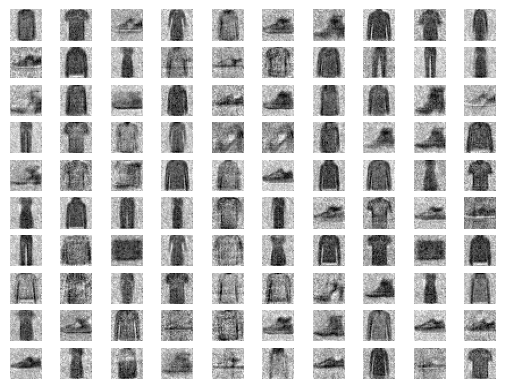

In [30]:
latent_dim = 100
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=20, n_batch=64)

In [32]:
model = load_model('model_18740.h5')
# model = tf.keras.models.load_model('model_18740.h5')
latent_dim = 100
n_examples = 100
latent_points = generate_latent_points(latent_dim, n_examples)
X  = model.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, n_examples)

4/4 [==============================] - 0s 8ms/step


ValueError: ignored

<Figure size 640x480 with 0 Axes>